# Defining Known Variables

In [40]:
import numpy as np
from scipy.linalg import expm
import pandas as pd
# Define Variables
u = 398600 # km^3/s^2
dt = 10 # s
x0 = 6678 # km
y0 = 0 # km
xd0 = 0 # km/s
yd0 = x0*(u/x0**3)**(1/2) # km/s
w = (2*np.pi)/86400 # rad/s
Re = 6378 # km


## Define Tracking Station Functions

In [2]:
def theta(i):
    return (i)*(np.pi/6)

def xs(t, i):
    return Re*np.cos(w * t + theta(i))

def ys(t, i):
    return Re*np.sin(w * t + theta(i))

def xsd(t, i):
    return -Re*w*np.sin(w * t + theta(i))

def ysd(t, i):
    return Re*w*np.cos(w * t + theta(i))


## Define Jacobian Matrices and Evaluate at Initial Conditions

In [3]:
# Define Matrices

x = x0
y = y0
xd = xd0
yd = yd0
dx = xd
dy = yd

# A Matrix
# A = np.array([[0,1,0,0],
#               [-u*(y**2 - 2*x**2)/(y**2 + x**2)**(5/2),0,3*u*x*y/(y**2 + x**2)**(5/2),0],
#               [0,0,0,1],
#               [3*u*x*y/(y**2 + x**2)**(5/2),0,-u*(x**2 - 2*y**2)/(y**2 + x**2)**(5/2),0]])

A = np.array([[0,1,0,0],
              [3.0*u*x**2/(x**2 + y**2)**2.5 - u/(x**2 + y**2)**1.5,0,3.0*u*x*y/(x**2 + y**2)**2.5,0],
              [0,0,0,1],
              [3.0*u*x*y/(x**2 + y**2)**2.5,0,3.0*u*y**2/(x**2 + y**2)**2.5 - u/(x**2 + y**2)**1.5,0]])

# B Matrix
B = np.array([[0,0],
              [1,0],
              [0,0],
              [0,1]])


# C Matrix
C = []
for i in range(12):
    xs_i = xs(0, i)
    ys_i = ys(0, i)
    xsd_i = xsd(0, i)
    ysd_i = ysd(0, i)
    dxs = xsd_i
    dys = ysd_i

    # C_i = np.array([[(x-xs_i)/((x-xs_i)**2 + (y-ys_i)**2)**(1/2),0,(y-ys_i)/((x-xs_i)**2 + (y-ys_i)**2)**(1/2),0],
    #             [(y - ys_i)*((xd-xsd_i) * (y - ys_i) - (yd - ysd_i)*(x - xs_i))/((x - xs_i)**2 + (y - ys_i)**2)**(3/2),
    #             ((x-xs_i)**2)/((x - xs_i)**2 + (y - ys_i)**2)**(1/2),
    #             (x - xs_i)*((yd-ysd_i) * (x - xs_i) - (xd - xsd_i)*(y - ys_i))/((x - xs_i)**2 + (y - ys_i)**2)**(3/2),
    #             ((y-ys_i)**2)/((x - xs_i)**2 + (y - ys_i)**2)**(1/2)],
    #             [-1*(y-ys_i)/((x-xs_i)**2 + (y-ys_i)**2),0,(x-xs_i)/((x-xs_i)**2 + (y-ys_i)**2),0]])

    C_i = np.array([[(x-xs_i)/((x-xs_i)**2 + (y-ys_i)**2)**(1/2),0,(y-ys_i)/((x-xs_i)**2 + (y-ys_i)**2)**(1/2),0],
                [(dx - dxs)/((x - xs_i)**2 + (y - ys_i)**2)**0.5 + (-1.0*x + 1.0*xs_i)*((dx - dxs)*(x - xs_i) + (-dys + dy)*(y - ys_i))/((x - xs_i)**2 + (y - ys_i)**2)**1.5,
                (x - xs_i)/((x - xs_i)**2 + (y - ys_i)**2)**0.5,
                (-dys + dy)/((x - xs_i)**2 + (y - ys_i)**2)**0.5 + (-1.0*y + 1.0*ys_i)*((dx - dxs)*(x - xs_i) + (-dys + dy)*(y - ys_i))/((x - xs_i)**2 + (y - ys_i)**2)**1.5,
                (y - ys_i)/((x - xs_i)**2 + (y - ys_i)**2)**0.5],
                [-1*(y-ys_i)/((x-xs_i)**2 + (y-ys_i)**2),0,(x-xs_i)/((x-xs_i)**2 + (y-ys_i)**2),0]])

    C.append(C_i)

# D Matrix
D = np.array([[0,0],
              [0,0],
              [0,0]])

## Define Discrete Time Matrices

In [4]:
# Discrete time matrices
Ad = expm(A * dt)
Bd = np.linalg.inv(A) @ (Ad - np.eye(4)) @ B  # Only if A is invertible
Cd = C
Dd = D

In [5]:
print(Ad)
print(Bd)
print(Cd)
print(Dd)

[[ 1.00013385e+00  1.00004462e+01  0.00000000e+00  0.00000000e+00]
 [ 2.67699415e-05  1.00013385e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  9.99933079e-01  9.99977693e+00]
 [ 0.00000000e+00  0.00000000e+00 -1.33840750e-05  9.99933079e-01]]
[[50.00111537  0.        ]
 [10.00044615  0.        ]
 [ 0.         49.99944232]
 [ 0.          9.99977693]]
[array([[ 1.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  1.        ,  0.02420671,  0.        ],
       [-0.        ,  0.        ,  0.00333333,  0.        ]]), array([[ 3.40402514e-01,  0.00000000e+00, -9.40279814e-01,
         0.00000000e+00],
       [ 7.51665622e-04,  3.40402514e-01,  2.72119920e-04,
        -9.40279814e-01],
       [ 2.77242436e-04,  0.00000000e+00,  1.00368019e-04,
         0.00000000e+00]]), array([[ 5.34044128e-01,  0.00000000e+00, -8.45456604e-01,
         0.00000000e+00],
       [ 5.61857693e-04,  5.34044128e-01,  3.54905030e-04,
        -8.45456604e-01],
       [ 

In [6]:
# Calculate A, B, C, D at Nominal Points
def get_nominal_points(t, T):
    theta_nom = (t/T)*(2*np.pi)
    x = np.cos(theta_nom) * x0
    y = np.sin(theta_nom) * x0
    xd = -1*np.sin(theta_nom) * x0 * (u/x0**3)**(1/2)
    yd = np.cos(theta_nom) * x0 * (u/x0**3)**(1/2)
    return x, y, xd, yd

In [7]:
# Calculate A, B, C, D at Nominal Points
def get_nominal_matrices(t, T):
    x, y, dx, dy = get_nominal_points(t, T)
    
    # A = np.array([[0,1,0,0],
    #               [3.0*u*x**2/(x**2 + y**2)**2.5 - u/(x**2 + y**2)**1.5,0,3.0*u*x*y/(x**2 + y**2)**2.5,0],
    #               [0,0,0,1],
    #               [3.0*u*x*y/(x**2 + y**2)**2.5,0,3.0*u*y**2/(x**2 + y**2)**2.5 - u/(x**2 + y**2)**1.5,0]])

    A = np.array([[0,1,0,0],
                  [2.0*u*x**2/(x**2 + y**2)**2.5 - (u*y**2)/(x**2 + y**2)**2.5,0,3.0*u*x*y/(x**2 + y**2)**2.5,0],
                  [0,0,0,1],
                  [3.0*u*x*y/(x**2 + y**2)**2.5,0,2.0*u*y**2/(x**2 + y**2)**2.5 - (u*x**2)/(x**2 + y**2)**2.5,0]])
                  
    B = np.array([[0,0],
                  [1,0],
                  [0,0],
                  [0,1]])

    # C Matrix
    C = []

    for i in range(12):
        xs_i = xs(t, i)
        ys_i = ys(t, i)
        xsd_i = xsd(t, i)
        ysd_i = ysd(t, i)
        dxs = xsd_i
        dys = ysd_i

        C_i = np.array([[(x-xs_i)/((x-xs_i)**2 + (y-ys_i)**2)**(1/2),0,(y-ys_i)/((x-xs_i)**2 + (y-ys_i)**2)**(1/2),0],
                    [(dx - dxs)/((x - xs_i)**2 + (y - ys_i)**2)**0.5 + (-1.0*x + 1.0*xs_i)*((dx - dxs)*(x - xs_i) + (-dys + dy)*(y - ys_i))/((x - xs_i)**2 + (y - ys_i)**2)**1.5,
                    (x - xs_i)/((x - xs_i)**2 + (y - ys_i)**2)**0.5,
                    (-dys + dy)/((x - xs_i)**2 + (y - ys_i)**2)**0.5 + (-1.0*y + 1.0*ys_i)*((dx - dxs)*(x - xs_i) + (-dys + dy)*(y - ys_i))/((x - xs_i)**2 + (y - ys_i)**2)**1.5,
                    (y - ys_i)/((x - xs_i)**2 + (y - ys_i)**2)**0.5],
                    [-1*(y-ys_i)/((x-xs_i)**2 + (y-ys_i)**2),0,(x-xs_i)/((x-xs_i)**2 + (y-ys_i)**2),0]])

        C.append(C_i)

    # D Matrix
    D = np.array([[0,0],
                  [0,0],
                  [0,0]])
    A_hat =  np.concatenate((A, B), axis=1)
    A_hat = np.concatenate((A_hat, np.zeros((np.shape(A_hat)[1]-np.shape(A_hat)[0], np.shape(A_hat)[1]))), axis=0)
    Ad_expm = expm(A_hat * dt)
    Ad =  Ad_expm[0:np.shape(A)[0], 0:np.shape(A)[1]]
    Bd = Ad_expm[0:np.shape(A)[0], np.shape(A)[1]:]
    #Bd = np.linalg.inv(A) @ (Ad - np.eye(4)) @ B  # Only if A is invertible
    Cd = C
    Dd = D

    return Ad, Bd, Cd, Dd, np.array([[x], [dx], [y], [dy]]), np


In [17]:
# Calculate Initital Y Conditions
def get_initial_y_conditions(t, T, station):

    # Get Nominal Points
    x, y, dx, dy = get_nominal_points(t, T)

    # Get Station Points
    xs_i = xs(t, i)
    ys_i = ys(t, i)
    xsd_i = xsd(t, i)
    ysd_i = ysd(t, i)
    dxs = xsd_i
    dys = ysd_i

    # Calculate Y Conditions
    rho    = np.sqrt((x-xs_i)**2 + (y-ys_i)**2)
    rhodot = ((x-xs_i)*(dx-dxs) + (y-ys_i)*(dy-dys))/rho
    phi    = np.arctan2((y-ys_i),(x-xs_i))

    return np.array([[rho], [rhodot], [phi]])


## Simulation Loop (DT)

In [19]:
# Discrete Time Simulation
x_history = []
y_history = []
T_orb = round(np.sqrt((4*(np.pi**2)*(x0**3))/u))
# Initial Conditions
initial_x = np.array([[x0], [xd0], [y0], [yd0]])
initial_y = [get_initial_y_conditions(0, T_orb, i) for i in range(1,13)]
x_input = initial_x
input_u = np.array([[0], [0]])
x_dx = np.array([[0],[0.075],[0],[-0.021]])
x_history.append(initial_x + x_dx)
# Simulation Loop
Ad, Bd, Cd, Dd, x_new = get_nominal_matrices(0, T_orb)
for k in range(10,14000, 10):
    y_temp = []
    x_dx = Ad @ x_dx + Bd @ input_u
    for i in range(12):
        y_nom = get_initial_y_conditions(k, T_orb, i)
        y_temp.append(y_nom + Cd[i] @ x_dx + Dd @ input_u)
        
    Ad, Bd, Cd, Dd, x_new = get_nominal_matrices(k, T_orb)
    x_history.append(x_dx+x_new)
    y_history.append(y_temp)


In [39]:
print(np.array(y_history)[1][0], len(np.array(y_history)[1][0]))
print(np.array(y_history)[1][1], len(np.array(y_history)[1][1]))
print(np.array(y_history)[1][2], len(np.array(y_history)[1][2]))

[[333.06006427   4.3775803    1.81227148]
 [331.75146308   3.0689791    0.50367029]
 [331.6984996    3.01601562   0.45070681]] 3
[[ 3.25613018e+03 -5.90915806e+00 -2.91581039e-01]
 [ 3.25526127e+03 -6.77807673e+00 -1.16049970e+00]
 [ 3.25521484e+03 -6.82450645e+00 -1.20692942e+00]] 3
[[ 6.41152713e+03 -4.99579180e+00  1.69075859e-01]
 [ 6.41042281e+03 -6.10011706e+00 -9.35249396e-01]
 [ 6.41036411e+03 -6.15881681e+00 -9.93949145e-01]] 3


In [31]:
X_array = pd.DataFrame(np.array(x_history)[:,0], columns=['X Position'])    
Xd_array = pd.DataFrame(np.array(x_history)[:,1], columns=['X Velocity'])
Y_array = pd.DataFrame(np.array(x_history)[:,2], columns=['Y Position'])
Yd_array = pd.DataFrame(np.array(x_history)[:,3], columns=['Y Velocity'])
rho_array = pd.DataFrame(np.array(y_history)[:,:,0].squeeze(), columns=['rho 1', 'rho 2', 'rho 3', 'rho 4', 'rho 5', 'rho 6', 'rho 7', 'rho 8', 'rho 9', 'rho 10', 'rho 11', 'rho 12'])
rhod_array = pd.DataFrame(np.array(y_history)[:,:,1].squeeze(), columns=['rhod 1', 'rhod 2', 'rhod 3', 'rhod 4', 'rhod 5', 'rhod 6', 'rhod 7', 'rhod 8', 'rhod 9', 'rhod 10', 'rhod 11', 'rhod 12'])
phi_array = pd.DataFrame(np.array(y_history)[:,:,2].squeeze(), columns=['phi 1', 'phi 2', 'phi 3', 'phi 4', 'phi 5', 'phi 6', 'phi 7', 'phi 8', 'phi 9', 'phi 10', 'phi 11', 'phi 12'])

ValueError: Must pass 2-d input. shape=(1399, 12, 3)

In [15]:
x_history[1000][0]

array([4105.57374727])

In [16]:
import plotly.express as px

# Create figure with secondary y-axis
fig = px.line(X_array, y="X Position", title="X Position vs Time", range_x=[0,1400])
fig.show()

fig = px.line(Xd_array, y="X Velocity", title="X Velocity vs Time", range_x=[0,1400])
fig.show()

fig = px.line(Y_array, y="Y Position", title="Y Position vs Time", range_x=[0,1400])
fig.show()

fig = px.line(Yd_array, y="Y Velocity", title="Y Velocity vs Time", range_x=[0,1400])
fig.show()

fig = px.line(rho_array, y=["rho 1", "rho 2", "rho 3", "rho 4", "rho 5", "rho 6", "rho 7", "rho 8", "rho 9", "rho 10", "rho 11", "rho 12"], title="rho vs Time", range_x=[0,1400])
fig.show()

fig = px.line(rhod_array, y=["rhod 1", "rhod 2", "rhod 3", "rhod 4", "rhod 5", "rhod 6", "rhod 7", "rhod 8", "rhod 9", "rhod 10", "rhod 11", "rhod 12"], title="rhod vs Time", range_x=[0,1400])
fig.show()

fig = px.line(phi_array, y=["phi 1", "phi 2", "phi 3", "phi 4", "phi 5", "phi 6", "phi 7", "phi 8", "phi 9", "phi 10", "phi 11", "phi 12"], title="phi vs Time", range_x=[0,1400])
fig.show()



# Checking Derivations

In [12]:
from sympy import *
# Derive the equations
x, dx, y, dy, xs, dxs, ys, dys = symbols('x dx y dy xs dxs ys dys')
f = ((x - xs)*(dx - dxs) + (y - ys)*(dy - dys))/((x - xs)**2 + (y - ys)**2)**(1/2)
f_wrx = diff(f, x)
f_wry = diff(f, y)
f_wrdx = diff(f, dx)
f_wrdy = diff(f, dy)


In [13]:
print(f_wrx)
print(f_wry)
print(f_wrdx)
print(f_wrdy)

(dx - dxs)/((x - xs)**2 + (y - ys)**2)**0.5 + (-1.0*x + 1.0*xs)*((dx - dxs)*(x - xs) + (dy - dys)*(y - ys))/((x - xs)**2 + (y - ys)**2)**1.5
(dy - dys)/((x - xs)**2 + (y - ys)**2)**0.5 + (-1.0*y + 1.0*ys)*((dx - dxs)*(x - xs) + (dy - dys)*(y - ys))/((x - xs)**2 + (y - ys)**2)**1.5
(x - xs)/((x - xs)**2 + (y - ys)**2)**0.5
(y - ys)/((x - xs)**2 + (y - ys)**2)**0.5


In [14]:
x, dx, ddx, y, dy, ddy, u1, w1, u2, w2, u = symbols('x dx ddx y dy ddy u1 w1 u2 w2 u')
ddx = (-1*u*x)/((x**2 + y**2)**(1/2))**3 + u1 + w1
ddy = (-1*u*y)/((x**2 + y**2)**(1/2))**3 + u2 + w2
ddx_wrx = diff(ddx, x)
ddx_wry = diff(ddx, y)
ddy_wrx = diff(ddy, x)
ddy_wry = diff(ddy, y)
print(ddx_wrx)
print(ddx_wry)
print(ddy_wrx)
print(ddy_wry)

3.0*u*x**2/(x**2 + y**2)**2.5 - u/(x**2 + y**2)**1.5
3.0*u*x*y/(x**2 + y**2)**2.5
3.0*u*x*y/(x**2 + y**2)**2.5
3.0*u*y**2/(x**2 + y**2)**2.5 - u/(x**2 + y**2)**1.5


# ODE 45 Solution

/Users/almustaphasilvester/Desktop/Graduate School (CU Boulder)/FALL 2024/ASEN 5044 - Statistical Estimation for Dynamical Systems/Final Project/.venv/lib/python3.10/site-packages/scipy/integrate/_ivp/ivp.py:621: UserWarning: The following arguments have no effect for a chosen solver: `reltol`.
  solver = method(fun, t0, y0, tf, vectorized=vectorized, **options)


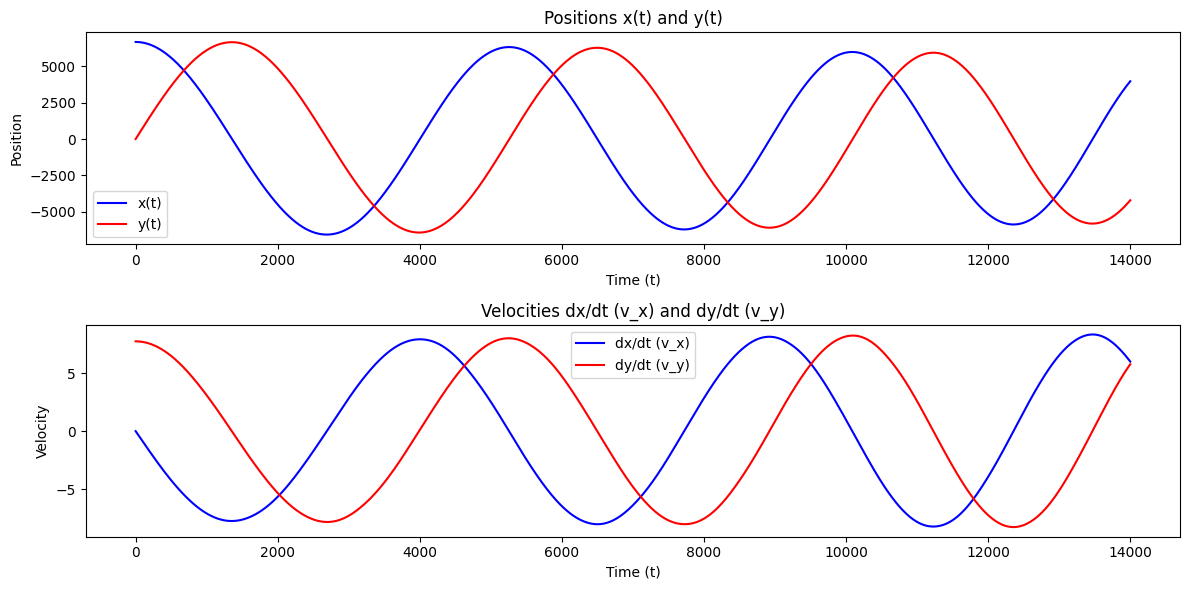

In [52]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Parameters
u = 398600     # Constant parameter u
u1 = 0    # Constant parameter u1
u2 = 0     # Constant parameter u2
w1 = 0     # Constant parameter w1
w2 = 0     # Constant parameter w2

# Define the system of first-order ODEs
def system(t, state):
    x, v_x, y, v_y = state
    
    # Compute the derivatives
    dx_dt = v_x
    dvx_dt = (-u * x) / (x**2 + y**2)**(3/2) + u1 + w1
    dy_dt = v_y
    dvy_dt = (-u * y) / (x**2 + y**2)**(3/2) + u2 + w2
    
    return [dx_dt, dvx_dt, dy_dt, dvy_dt]

# Initial conditions: x(0), dx(0), y(0), dy(0)
initial_conditions = [6678, 0.0, 0.0, 7.725835197559566]  # For example, starting at x=1, y=0, with zero velocity

# Time span for the solution
t_span = (0, 14001)  # From t=0 to t=10
t_eval = np.linspace(0, 14000, 14000)  # Times at which we want the solution

# Solve the system using solve_ivp
solution = solve_ivp(system, t_span, initial_conditions, t_eval=t_eval, reltol=1e-5 )

# Extract the results from the solution
x_vals = solution.y[0]
v_x_vals = solution.y[1]
y_vals = solution.y[2]
v_y_vals = solution.y[3]

# Plot the results
plt.figure(figsize=(12, 6))

# Plot x and y over time
plt.subplot(2, 1, 1)
plt.plot(solution.t, x_vals, label='x(t)', color='b')
plt.plot(solution.t, y_vals, label='y(t)', color='r')

plt.xlabel('Time (t)')
plt.ylabel('Position')
plt.legend()
plt.title('Positions x(t) and y(t)')

# Plot the velocities v_x and v_y over time
plt.subplot(2, 1, 2)
plt.plot(solution.t, v_x_vals, label='dx/dt (v_x)', color='b')
plt.plot(solution.t, v_y_vals, label='dy/dt (v_y)', color='r')
plt.xlabel('Time (t)')
plt.ylabel('Velocity')
plt.legend()
plt.title('Velocities dx/dt (v_x) and dy/dt (v_y)')


plt.tight_layout()
plt.show()


In [16]:
# Take every 10th value from y_vals to match x_history sampling
y_vals_sampled = y_vals[::10]
v_y_vals_sampled = v_y_vals[::10]

# Calculate residuals using the sampled values
y_residual = y_vals_sampled - np.array(x_history)[:,2].flatten()
vy_residual = v_y_vals_sampled - np.array(x_history)[:,3].flatten()
# Plot the residuals
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(np.linspace(0,14000,1400), y_residual, label='y position residual')
plt.xlabel('Time (t)')
plt.ylabel('Position Residual')
plt.legend()
plt.title('Position Residual y(t) - y_history(t)')

plt.subplot(2, 1, 2)
plt.plot(np.linspace(0,14000,1400), vy_residual, label='y velocity residual') 
plt.xlabel('Time (t)')
plt.ylabel('Velocity Residual')
plt.legend()
plt.title('Velocity Residual v_y(t) - v_y_history(t)')

plt.show()


ValueError: operands could not be broadcast together with shapes (1400,) (1401,) 

In [41]:
def theta(i):
    return (i)*(np.pi/6)

def xs(t, i):
    return Re*np.cos(w * t + theta(i))

def ys(t, i):
    return Re*np.sin(w * t + theta(i))

def xsd(t, i):
    return -Re*w*np.sin(w * t + theta(i))

def ysd(t, i):
    return Re*w*np.cos(w * t + theta(i))

In [42]:
# Calculate A, B, C, D at Nominal Points
def get_nominal_points(t, T):
    theta_nom = (t/T)*(2*np.pi)
    x = np.cos(theta_nom) * x0
    y = np.sin(theta_nom) * x0
    xd = -1*np.sin(theta_nom) * x0 * (u/x0**3)**(1/2)
    yd = np.cos(theta_nom) * x0 * (u/x0**3)**(1/2)
    return x, y, xd, yd

In [43]:
# Calculate A, B, C, D at Nominal Points
def get_nominal_matrices(t, T):
    x, y, dx, dy = get_nominal_points(t, T)
    
    # A = np.array([[0,1,0,0],
    #               [3.0*u*x**2/(x**2 + y**2)**2.5 - u/(x**2 + y**2)**1.5,0,3.0*u*x*y/(x**2 + y**2)**2.5,0],
    #               [0,0,0,1],
    #               [3.0*u*x*y/(x**2 + y**2)**2.5,0,3.0*u*y**2/(x**2 + y**2)**2.5 - u/(x**2 + y**2)**1.5,0]])

    A = np.array([[0,1,0,0],
                  [2.0*u*x**2/(x**2 + y**2)**2.5 - (u*y**2)/(x**2 + y**2)**2.5,0,3.0*u*x*y/(x**2 + y**2)**2.5,0],
                  [0,0,0,1],
                  [3.0*u*x*y/(x**2 + y**2)**2.5,0,2.0*u*y**2/(x**2 + y**2)**2.5 - (u*x**2)/(x**2 + y**2)**2.5,0]])
                  
    B = np.array([[0,0],
                  [1,0],
                  [0,0],
                  [0,1]])

    # C Matrix
    C = []

    for i in range(12):
        xs_i = xs(t, i)
        ys_i = ys(t, i)
        xsd_i = xsd(t, i)
        ysd_i = ysd(t, i)
        dxs = xsd_i
        dys = ysd_i

        C_i = np.array([[(x-xs_i)/((x-xs_i)**2 + (y-ys_i)**2)**(1/2),0,(y-ys_i)/((x-xs_i)**2 + (y-ys_i)**2)**(1/2),0],
                    [(dx - dxs)/((x - xs_i)**2 + (y - ys_i)**2)**0.5 + (-1.0*x + 1.0*xs_i)*((dx - dxs)*(x - xs_i) + (-dys + dy)*(y - ys_i))/((x - xs_i)**2 + (y - ys_i)**2)**1.5,
                    (x - xs_i)/((x - xs_i)**2 + (y - ys_i)**2)**0.5,
                    (-dys + dy)/((x - xs_i)**2 + (y - ys_i)**2)**0.5 + (-1.0*y + 1.0*ys_i)*((dx - dxs)*(x - xs_i) + (-dys + dy)*(y - ys_i))/((x - xs_i)**2 + (y - ys_i)**2)**1.5,
                    (y - ys_i)/((x - xs_i)**2 + (y - ys_i)**2)**0.5],
                    [-1*(y-ys_i)/((x-xs_i)**2 + (y-ys_i)**2),0,(x-xs_i)/((x-xs_i)**2 + (y-ys_i)**2),0]])

        C.append(C_i)

    # D Matrix
    D = np.array([[0,0],
                  [0,0],
                  [0,0]])
    A_hat =  np.concatenate((A, B), axis=1)
    A_hat = np.concatenate((A_hat, np.zeros((np.shape(A_hat)[1]-np.shape(A_hat)[0], np.shape(A_hat)[1]))), axis=0)
    Ad_expm = expm(A_hat * dt)
    Ad =  Ad_expm[0:np.shape(A)[0], 0:np.shape(A)[1]]
    Bd = Ad_expm[0:np.shape(A)[0], np.shape(A)[1]:]
    #Bd = np.linalg.inv(A) @ (Ad - np.eye(4)) @ B  # Only if A is invertible
    Cd = C
    Dd = D

    return Ad, Bd, Cd, Dd, np.array([[x], [dx], [y], [dy]])

In [52]:
import sympy as sp
import matplotlib.pyplot as plt

class system:

    # Define System Parameters
    def __init__(self, variables: dict, equations_of_motion: dict, constants: dict, 
                 initial_conditions: dict, process_noise: dict, measurement_noise: dict,
                 T_orbital: float):

        self.variables = variables
        self.equations_of_motion = equations_of_motion
        self.constants = constants
        self.initial_conditions = initial_conditions
        self.process_noise = process_noise
        self.measurement_noise = measurement_noise

    # Define System Equations
    def define_state_vector(self):

        # Define State Variables
        x, dx, y, dy, x_s, dx_s, y_s, dy_s = symbols(self.variables["state"])
        u1, u2 = symbols(self.variables["input"])

        # Define State Vector and Output Vector
        f_x = sp.Matrx(list(self.equations_of_motion["state"].values()))
        f_y = sp.Matrx(list(self.equations_of_motion["output"].values()))

        # Get Jacobian of State Vector and Input Vector
        self.A = f_x.jacobian([x, dx, y, dy])
        self.B = f_x.jacobian([u1, u2])
        self.C = f_y.jacobian([x, dx, y, dy])
        self.D = f_y.jacobian([u1, u2])

        return None
    
    # Calculate Nominal Points
    def calculate_nominal_points(self, t, T):
        theta_nom = (t/T)*(2*np.pi)
        x = np.cos(theta_nom) * x0
        y = np.sin(theta_nom) * x0
        xd = -1*np.sin(theta_nom) * x0 * (u/x0**3)**(1/2)
        yd = np.cos(theta_nom) * x0 * (u/x0**3)**(1/2)
        return x, y, xd, yd

    # Calculate Tracking Stations
    def caclulate_tracking_stations(self, station_number, t, T):
        theta = (station_number)*(np.pi/6)
        x_s = Re*np.cos(w * t + theta)
        y_s = Re*np.sin(w * t + theta)
        xd_s = -Re*w*np.sin(w * t + theta)
        yd_s = Re*w*np.cos(w * t + theta)
        return x_s, y_s, xd_s, yd_s

    # Evaluate Jacobian Matrices
    def evaluate_jacobian_matrices(self, t, T):
        x, y, dx, dy = self.calculate_nominal_points(t, T)
        x_s, y_s, xd_s, yd_s = self.caclulate_tracking_stations(1, t, T)
        A = self.A.subs({x:x, dx:dx, y:y, dy:dy, x_s: x_s, dx_s: dx_s, y_s: y_s, dy_s: dy_s, u1: 0, u2: 0})
        B = self.B.subs({x:x, dx:dx, y:y, dy:dy, x_s: x_s, dx_s: dx_s, y_s: y_s, dy_s: dy_s, u1: 0, u2: 0})
        C = self.C.subs({x:x, dx:dx, y:y, dy:dy, x_s: x_s, dx_s: dx_s, y_s: y_s, dy_s: dy_s, u1: 0, u2: 0})
        D = self.D.subs({x:x, dx:dx, y:y, dy:dy, x_s: x_s, dx_s: dx_s, y_s: y_s, dy_s: dy_s, u1: 0, u2: 0})
        return A, B, C, D

    # DT Simulation
    def dt_simulation(self, t, T):
        
        # Store Results
        x_results = []
        y_results = []

        # Initialize State Vector
        dx_nominal = np.array([[0],[0.075],[0],[-0.021]])
        x_results.append(self.initial_conditions["state"] + dx_nominal)
        y_results.append(self.initial_conditions["output"])

        # Simulation Loop
        for t in range(t, T, dt):
            x, y, dx, dy = self.calculate_nominal_points(t, T)
            A, B, C, D = self.evaluate_jacobian_matrices(t, T)
            x_nominal = np.array([[x], [dx], [y], [dy]])
            dx_nominal = A @ dx_nominal + B @ u1
            dy_nominal = C @ dx_nominal + D @ u2
            x_results.append(x_nominal + dx_nominal)
            y_results.append(y_nominal + dy_nominal)

        # Plot Results
        # Convert results lists to numpy arrays for plotting
        x_results = np.array(x_results)
        y_results = np.array(y_results)

        # Create figure with two subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

        # Plot positions vs time
        ax1.plot(range(len(x_results)), x_results[:,0], label='x position')
        ax1.plot(range(len(x_results)), x_results[:,2], label='y position') 
        ax1.set_xlabel('Time Step')
        ax1.set_ylabel('Position')
        ax1.legend()
        ax1.grid(True)

        # Plot velocities vs time
        ax2.plot(range(len(x_results)), x_results[:,1], label='x velocity')
        ax2.plot(range(len(x_results)), x_results[:,3], label='y velocity')
        ax2.set_xlabel('Time Step')
        ax2.set_ylabel('Velocity')
        ax2.legend()
        ax2.grid(True)

        plt.tight_layout()
        plt.show()



In [15]:
# Discrete Time Simulation
x_history = []
y_history = []
T_orb = round(np.sqrt((4*(np.pi**2)*(x0**3))/mu))
# Initial Conditions
initial_x = np.array([[x0], [xd0], [y0], [yd0]])
initial_y = [get_initial_y_conditions(0, T_orb, i) for i in range(1,13)]
x_input = initial_x
input_u = np.array([[0], [0]])
x_dx = np.array([[0],[0.075],[0],[-0.021]])
x_history.append(initial_x + x_dx)
# Simulation Loop
Ad, Bd, Cd, Dd, x_new = get_nominal_matrices(0, T_orb)
for k in range(10,14000, 10):
    y_temp = []
    x_dx = Ad @ x_dx + Bd @ input_u
    for i in range(12):
        y_nom = get_initial_y_conditions(k, T_orb, i)
        y_temp.append(y_nom + Cd[i] @ x_dx + Dd @ input_u)
        
    Ad, Bd, Cd, Dd, x_new = get_nominal_matrices(k, T_orb)
    x_history.append(x_dx+x_new)
    y_history.append(y_temp)

TypeError: loop of ufunc does not support argument 0 of type Mul which has no callable sqrt method

In [1]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt

# Define Symbols
x, y, dx, dy, x_s, dx_s, y_s, dy_s, mu = sp.symbols("x y dx dy x_s dx_s y_s dy_s mu")
u1, u2, w1, w2 = sp.symbols("u1 u2 w1 w2")

# Define System Equations
f1 = -mu*x*(1/((x**2 + y**2)**(1/2)))**3 + u1 + w1
f2 = -mu*y*(1/((x**2 + y**2)**(1/2)))**3 + u2 + w2
f3 = dx
f4 = dy
f5 = ((x-x_s)**2 + (y-y_s)**2)**(1/2)
f6 = ((x - x_s)*(dx - dx_s) + (y - y_s)*(dy - dy_s))/((x - x_s)**2 + (y - y_s)**2)**(1/2)
f7 = sp.atan2((y-y_s), (x-x_s))

# Define State Vector
f_x = sp.Matrix([f3, f1, f4, f2])

# Define Jacobians
A = f_x.jacobian([x, dx, y, dy])
B = f_x.jacobian([u1, u2])

# Define Output Vector
f_y = sp.Matrix([f5, f6, f7])

# Define Jacobians
C = f_y.jacobian([x, dx, y, dy])
D = f_y.jacobian([u1, u2])

Omega = f_x.jacobian([w1, w2])
Omega = np.array(Omega.tolist())


In [2]:
# Calculate Nominal Points
def calculate_nominal_points(t, T):
    theta_nom = (t/T)*(2*np.pi)
    x_nom = np.cos(theta_nom) * x0
    y_nom = np.sin(theta_nom) * x0
    xd_nom = -1*np.sin(theta_nom) * x0 * (mu_static/x0**3)**(1/2)
    yd_nom = np.cos(theta_nom) * x0 * (mu_static/x0**3)**(1/2)
    return x_nom, y_nom, xd_nom, yd_nom

# Calculate Tracking Stations
def caclulate_tracking_stations(station_number, t, T):
    theta = (station_number)*(np.pi/6)
    x_s = Re*np.cos(w * t + theta)
    y_s = Re*np.sin(w * t + theta)
    xd_s = -Re*w*np.sin(w * t + theta)
    yd_s = Re*w*np.cos(w * t + theta)
    return x_s, y_s, xd_s, yd_s

In [3]:
# Define Initial Conditions
mu_static = 398600
w = 2*np.pi/86400
Re = 6378
x0 = 6678
xd0 = 0
y0 = 0
yd0 = x0*((mu_static/x0**3)**(1/2))


In [4]:
# Discrete Time Simulation

# Set Up Simulation
x_history = []
y_history = []

# Define System Parameters
T_orbit = round(np.sqrt((4*(np.pi**2)*(x0**3))/mu_static))
initial_x = np.array([[x0], [xd0], [y0], [yd0]])

# Define Initial Conditions
perturbation_dx = np.array([[0],[0.075],[0],[-0.021]])
x_history.append(initial_x + perturbation_dx)

# Define Input
input_u = np.array([[0], [0]])

# Define Initial Jacobian Matrices
x_nom, y_nom, dx_nom, dy_nom = calculate_nominal_points(0, T_orbit)
#x_s, y_s, xd_s, yd_s = caclulate_tracking_stations(0, 0, T_orbit)
F = A.subs({x:x_nom, dx:dx_nom, y:y_nom, dy:dy_nom, mu: mu_static})
#G = B.subs({x:x, dx:dx, y:y, dy:dy, x_s: x_s, dx_s: xd_s, y_s: y_s, dy_s: yd_s, u1: 0, u2: 0, mu: mu, w: w, Re: Re})

for k in range(10,14000, 10):
    x_nom, y_nom, dx_nom, dy_nom = calculate_nominal_points(k, T_orbit)
    F = A.subs({x:x_nom, dx:dx_nom, y:y_nom, dy:dy_nom, mu: mu_static})
    perturbation_dx = F @ perturbation_dx
    x_history.append(perturbation_dx+np.array([[x_nom], [dx_nom], [y_nom], [dy_nom]]))
    #y_history.append(y_nom + Cd[i] @ x_dx + Dd @ input_u)



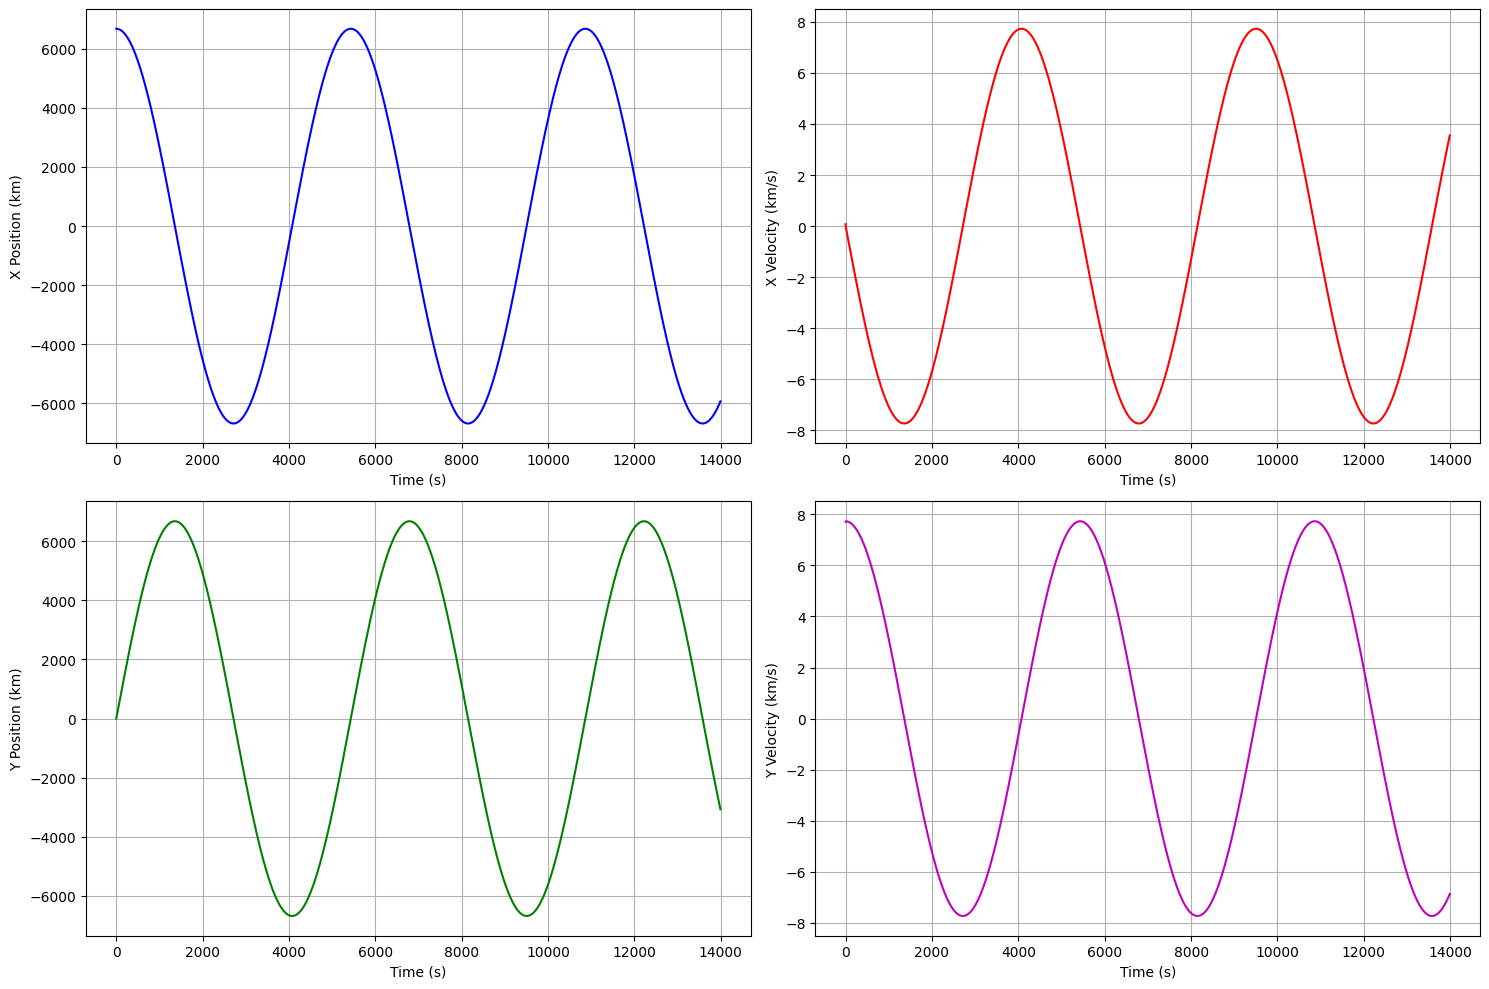

In [5]:
import matplotlib.pyplot as plt

# Convert x_history to numpy array for easier plotting
x_history_array = np.array(x_history)

# Create time vector
t = np.arange(0, len(x_history)*10, 10)

# Create subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Plot x position
ax1.plot(t, x_history_array[:,0], 'b-')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('X Position (km)')
ax1.grid(True)

# Plot x velocity 
ax2.plot(t, x_history_array[:,1], 'r-')
ax2.set_xlabel('Time (s)') 
ax2.set_ylabel('X Velocity (km/s)')
ax2.grid(True)

# Plot y position
ax3.plot(t, x_history_array[:,2], 'g-')
ax3.set_xlabel('Time (s)')
ax3.set_ylabel('Y Position (km)')
ax3.grid(True)

# Plot y velocity
ax4.plot(t, x_history_array[:,3], 'm-')
ax4.set_xlabel('Time (s)')
ax4.set_ylabel('Y Velocity (km/s)') 
ax4.grid(True)

plt.tight_layout()
plt.show()


# EKF Simulation

In [71]:
import pandas as pd
import time

def ekf_simulation(t_span, dt):
    # Initialize state and covariance
    x_init = np.array([[x0], [xd0], [y0], [yd0]])  # Initial state estimate (4x1)
    x_est = np.array([[0],[0.075],[0],[-0.021]])
    P = np.eye(4) * 100  # Initial covariance estimate (4x4)
    
    # Storage for results
    x_estimates = [x_est]
    P_history = [P]
    
    # Process and measurement noise covariances
    Q = np.eye(2) * 1e-10  # Process noise (4x4)
    R = np.array([[0.01,0,0],[0,1,0],[0,0,0.01]])  # Measurement noise for each station (3x3)

    # Get Non Linear Measure Function Results for phi
    
    # Simulation loop
    for k in range(dt, t_span, dt):

        if k%1000 == 0:
            print(f"Processing time step {k} of {t_span}")
        
        # 1. Prediction Step
        x_nom, y_nom, dx_nom, dy_nom = calculate_nominal_points(k, T_orbit)
        
        # Evaluate Jacobian A at current state estimate
        A_k = np.array(A.subs({
            x: x_est[0,0]+x_nom, dx: x_est[1,0]+dx_nom,
            y: x_est[2,0]+y_nom, dy: x_est[3,0]+dy_nom,
            mu: mu_static
        })).astype(np.float64)
        
        F_k = np.identity(np.shape(A_k)[0]) + dt*A_k#expm(A_k * dt)
        x_pred = F_k @ x_est
        P_pred = F_k @ P @ F_k.T + Omega @ Q @ Omega.T
        
        # 2. Update Step
        # Process all tracking stations at once
        # Get all station positions
        stations_pos = np.array([caclulate_tracking_stations(i, k, T_orbit) for i in range(12)])
        xs, ys, dxs, dys = stations_pos[:,0], stations_pos[:,1], stations_pos[:,2], stations_pos[:,3]

        z_stack = []
        out_of_range = []
        for i in range(12):
            phi_t = f7.xreplace({x: x_pred[0,0], y: x_pred[2,0], x_s: xs[i], y_s: ys[i]})
            theta_t = np.arctan2(ys[i], xs[i])
            if -np.pi+theta_t <= phi_t <= np.pi+theta_t:
                pass
            else:
                out_of_range.append(i)
        
        if len(out_of_range) == 12:
            print(f"All stations out of range at time step {k}")
            x_estimates.append(x_est+np.array([[x_nom], [dx_nom], [y_nom], [dy_nom]]))
            P_history.append(P_pred)
            continue

        # Remove out of range stations from position arrays
        xs = np.delete(xs, out_of_range)
        ys = np.delete(ys, out_of_range) 
        dxs = np.delete(dxs, out_of_range)
        dys = np.delete(dys, out_of_range)
        # Calculate measurement Jacobians for all stations (12x3x4)
        H = np.array([np.array(C.xreplace({
            x: x_pred[0,0]+x_nom, dx: x_pred[1,0]+dx_nom,
            y: x_pred[2,0]+y_nom, dy: x_pred[3,0]+dy_nom,
            x_s: xs[i], dx_s: dxs[i],
            y_s: ys[i], dy_s: dys[i]
        }).tolist()) for i in range(len(xs))])

        # Generate simulated measurements for all stations (12x3x1)
        rho = ((x_pred[0,0]+x_nom-xs)**2 + (x_pred[2,0]+y_nom-ys)**2)**(1/2)
        rhodot = ((x_pred[0,0]+x_nom-xs)*(x_pred[1,0]+dx_nom-dxs) + 
                 (x_pred[2,0]+y_nom-ys)*(x_pred[3,0]+dy_nom-dys))/rho
        phi = np.arctan2((x_pred[2,0]+y_nom-ys), (x_pred[0,0]+x_nom-xs))
        rho = np.array(rho)
        rhodot = np.array(rhodot)
        z = np.stack([rho, rhodot, phi], axis=1)[:,:,np.newaxis]

        # Stack measurements and Jacobians
        H_stack = np.vstack(H)  # (36x4)
        h_stack = np.vstack(z)  # (36x1)
        R_stack = np.kron(np.eye(len(xs)), R)  # (36x36)
        # Kalman update with stacked measurements
        S = H_stack @ P_pred @ H_stack.T + R_stack  # (36x36)
        S = S.astype(np.float64)
        K = P_pred @ H_stack.T @ np.linalg.inv(S) #S.inv()  # (4x36)

        


        # Predicted measurements
        z_stack = np.vstack([[f5.xreplace({x: solution.y[0][k%10], y: solution.y[2][k%10], x_s: xs[_], y_s: ys[_]}),
                             f6.xreplace({x: solution.y[0][k%10], y: solution.y[2][k%10], dx: solution.y[1][k%10], dy: solution.y[3][k%10], x_s: xs[_], y_s: ys[_], dx_s: dxs[_], dy_s: dys[_]}),
                             f7.xreplace({x: solution.y[0][k%10], y: solution.y[2][k%10], x_s: xs[_], y_s: ys[_]})
                             ] for _ in range(len(xs))])  # Stack measurements 12 times for 36 total rows

        z_stack = np.array(z_stack).reshape((len(xs)*3,1))
        
        # Update state and covariance
        x_pred = x_pred + K @ (z_stack - h_stack)  # (4x1)
        x_pred = np.array(x_pred).astype(np.float64)
        P_pred = (np.eye(4) - K @ H_stack) @ P_pred  # (4x4)
        
        # Store results after processing all stations
        x_est = x_pred
        P = P_pred
        x_estimates.append(x_est+np.array([[x_nom], [dx_nom], [y_nom], [dy_nom]]))
        P_history.append(P)
    
    return np.array(x_estimates), np.array(P_history)

In [72]:
est_x, est_P = ekf_simulation(14000, 10)


Processing time step 1000 of 14000
Processing time step 2000 of 14000
Processing time step 3000 of 14000
Processing time step 4000 of 14000
Processing time step 5000 of 14000
All stations out of range at time step 5430
All stations out of range at time step 5440
All stations out of range at time step 5450
All stations out of range at time step 5460
All stations out of range at time step 5470
All stations out of range at time step 5480
All stations out of range at time step 5490
All stations out of range at time step 5500
All stations out of range at time step 5510
All stations out of range at time step 5520
All stations out of range at time step 5530
All stations out of range at time step 5540
All stations out of range at time step 5550
All stations out of range at time step 5560
All stations out of range at time step 5570
All stations out of range at time step 5580
All stations out of range at time step 5590
All stations out of range at time step 5600
All stations out of range at time

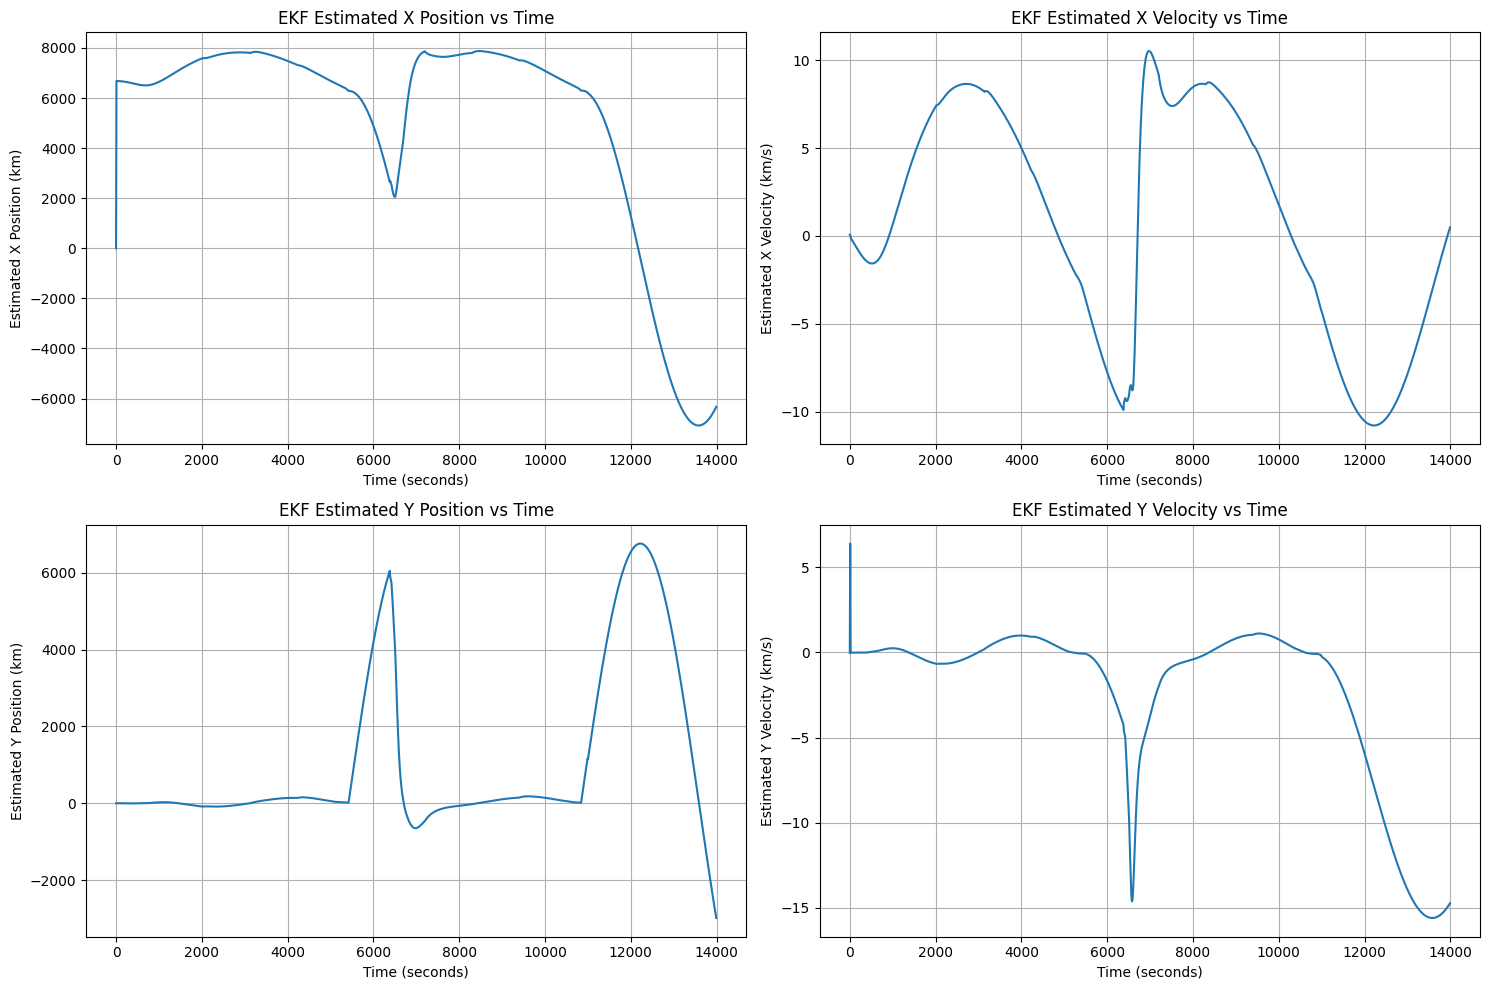

In [73]:
# Plot estimated states over time
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15,10))
time = np.arange(0, 14000, 10)  # Create time array from 0 to 14000s with 10s steps

# Plot x position
ax1.plot(time, np.array(est_x)[:,0,0])
ax1.set_xlabel('Time (seconds)')
ax1.set_ylabel('Estimated X Position (km)')
ax1.set_title('EKF Estimated X Position vs Time')
ax1.grid(True)

# Plot x velocity 
ax2.plot(time, np.array(est_x)[:,1,0])
ax2.set_xlabel('Time (seconds)')
ax2.set_ylabel('Estimated X Velocity (km/s)')
ax2.set_title('EKF Estimated X Velocity vs Time')
ax2.grid(True)

# Plot y position
ax3.plot(time, np.array(est_x)[:,2,0])
ax3.set_xlabel('Time (seconds)')
ax3.set_ylabel('Estimated Y Position (km)')
ax3.set_title('EKF Estimated Y Position vs Time')
ax3.grid(True)

# Plot y velocity
ax4.plot(time, np.array(est_x)[:,3,0])
ax4.set_xlabel('Time (seconds)')
ax4.set_ylabel('Estimated Y Velocity (km/s)')
ax4.set_title('EKF Estimated Y Velocity vs Time')
ax4.grid(True)

plt.tight_layout()
plt.show()
